### Setup

In [31]:
%env PYTORCH_ENABLE_MPS_FALLBACK=1

from dotenv import load_dotenv

load_dotenv()


env: PYTORCH_ENABLE_MPS_FALLBACK=1


True

In [2]:
import torch

device = torch.device(
    "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
)
device


device(type='mps')

### Create embeddings

In [6]:
from transformers import CLIPProcessor, CLIPModel

# model_name = "openai/clip-vit-large-patch14"
model_name = "openai/clip-vit-base-patch32"

model = CLIPModel.from_pretrained(model_name)
processor = CLIPProcessor.from_pretrained(model_name, clean_up_tokenization_spaces=True)


In [25]:
from PIL import Image
import torch

def extract_image_embedding(image_path: str):
    image = Image.open(image_path).convert('RGB')
    inputs = processor(images=image, return_tensors="pt")

    with torch.no_grad():
        embeddings = model.get_image_features(**inputs)

    return embeddings.squeeze().numpy()


In [29]:
from annoy import AnnoyIndex

dimension = 512 # 512 for base model, 1024 for large model
annoy_index = AnnoyIndex(dimension, 'angular')


In [30]:
import os
from tqdm.auto import tqdm

dataset_dir = "../data/dataset"
image_paths = []

for filename in tqdm(os.listdir(dataset_dir)):
    if not filename.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
        continue

    image_path = os.path.join(dataset_dir, filename)
    idx = int(filename.split(".")[0])

    embedding = extract_image_embedding(image_path)
    annoy_index.add_item(idx, embedding)
    image_paths.append(image_path)


  0%|          | 0/11537 [00:00<?, ?it/s]

In [31]:
num_trees = 100
annoy_index.build(num_trees)
annoy_index.save('../embeddings/uk_stamps.ann')


True

In [54]:
def find_similar_images(image_path, num_matches=5):
    embedding = extract_image_embedding(image_path)
    indices, distances = annoy_index.get_nns_by_vector(embedding, num_matches, include_distances=True)

    similar_images = [{ "path": f"{dataset_dir}/{idx}.jpg", "idx": idx, "distance": distances[i] } for i, idx in enumerate(indices)]

    return similar_images


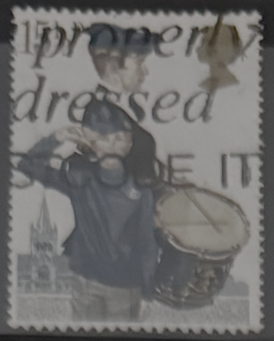

In [45]:
from PIL import Image
from IPython.display import display

stamp_sample = Image.open("../data/album/stamp1.png")
display(stamp_sample.resize((stamp_sample.width // 2, stamp_sample.height // 2)))


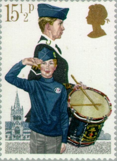

Distance: 0.48	 filename: 3591.jpg


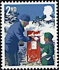

Distance: 0.67	 filename: 9697.jpg


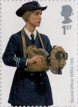

Distance: 0.68	 filename: 6972.jpg


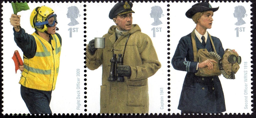

Distance: 0.71	 filename: 6970.jpg


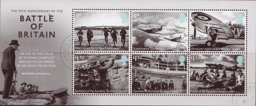

Distance: 0.71	 filename: 8858.jpg


In [60]:
similar_images = find_similar_images("../data/album/stamp1.1.jpg")
# similar_images = find_similar_images("../data/dataset/7962.jpg")
for image in similar_images:
    img = Image.open(image["path"])
    display(img.resize((img.width // 4, img.height // 4)))
    print(f"Distance: {image['distance']:.2f}\t filename: {image["idx"]}.jpg")


### Detect stamps in an album page

In [7]:
from transformers import GroundingDinoProcessor, GroundingDinoForObjectDetection

model_name = "IDEA-Research/grounding-dino-base"
model = GroundingDinoForObjectDetection.from_pretrained(model_name)
processor = GroundingDinoProcessor.from_pretrained(model_name)


In [3]:
import torch

def preprocess_caption(caption: str) -> str:
    result = caption.lower().strip()
    return result if result.endswith(".") else result + "."

def get_object_detection_results(image, text):
    inputs = processor(images=image, text=preprocess_caption(text), return_tensors="pt")

    with torch.no_grad():
        outputs = model(**inputs)

    width, height = image.size
    postprocessed_outputs = processor.image_processor.post_process_object_detection(outputs,
                                                                                    target_sizes=[(height, width)],
                                                                                    threshold=0.3)
    results = postprocessed_outputs[0]

    return results


In [4]:
import matplotlib.pyplot as plt

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def plot_results(pil_img, scores, labels, boxes, text):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for score, label, (xmin, ymin, xmax, ymax), c in zip(scores, labels, boxes, colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color=c, linewidth=3))
        label = f'{text}: {score:0.2f}'
        ax.text(xmin, ymin, label, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()


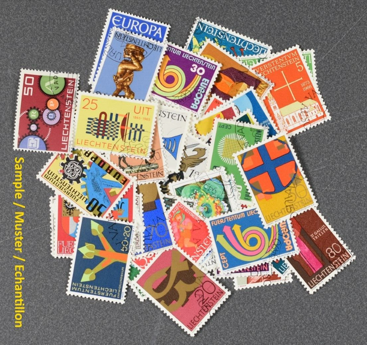

In [5]:
from PIL import Image
from IPython.display import display

album = Image.open("../data/album/lot1.jpg")
# rotate image counterclockwise
album = album.rotate(-90, expand=1)
display(album.resize((album.width // 3, album.height // 3)))


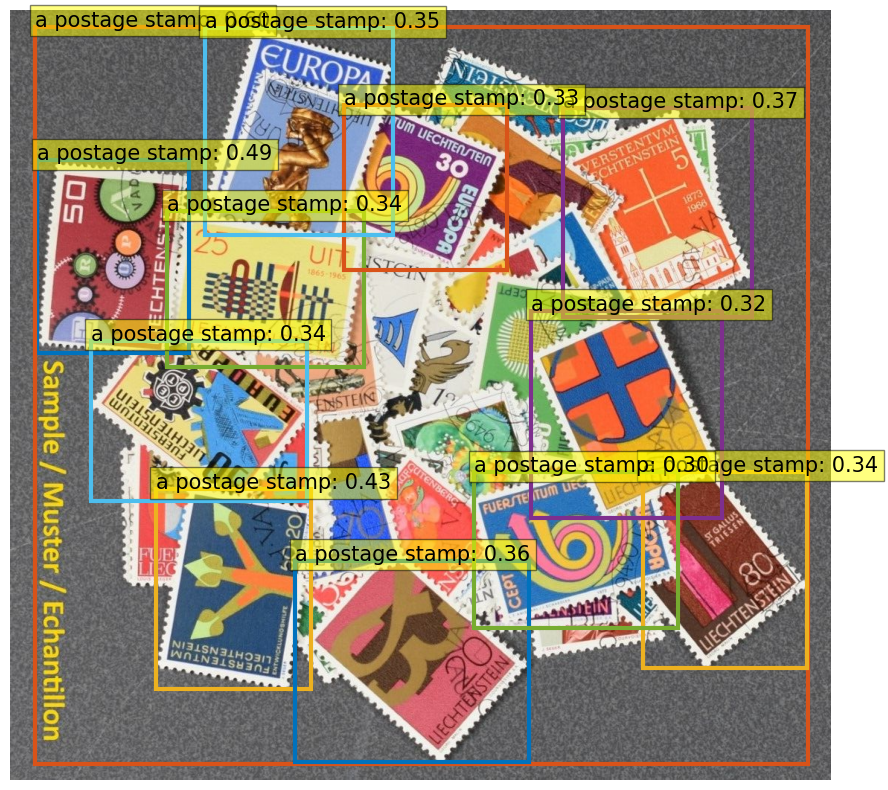

In [8]:
text = "a postage stamp"

results = get_object_detection_results(album, text)
plot_results(album, results['scores'].tolist(), results['labels'].tolist(), results['boxes'].tolist(), text)


In [79]:
print(f"Count of '{text}' detected: {len(results['scores'])}")


Count of 'a postage stamp' detected: 36


In [9]:
from transformers import pipeline

checkpoint = "google/owlv2-base-patch16-ensemble"
# checkpoint = "google/owlv2-large-patch14-ensemble"

detector = pipeline(model=checkpoint, task="zero-shot-object-detection", device=device)


[{'score': 0.3911226689815521, 'label': 'a postage stamp.', 'box': {'xmin': 65, 'ymin': 30, 'xmax': 1060, 'ymax': 1014}}, {'score': 0.33415934443473816, 'label': 'a postage stamp.', 'box': {'xmin': 41, 'ymin': 206, 'xmax': 238, 'ymax': 459}}, {'score': 0.25519952178001404, 'label': 'a postage stamp.', 'box': {'xmin': 217, 'ymin': 281, 'xmax': 472, 'ymax': 483}}, {'score': 0.21246960759162903, 'label': 'a postage stamp.', 'box': {'xmin': 123, 'ymin': 451, 'xmax': 401, 'ymax': 670}}, {'score': 0.2041729986667633, 'label': 'a postage stamp.', 'box': {'xmin': 264, 'ymin': 27, 'xmax': 513, 'ymax': 301}}, {'score': 0.1851961612701416, 'label': 'a postage stamp.', 'box': {'xmin': 198, 'ymin': 654, 'xmax': 407, 'ymax': 908}}, {'score': 0.17019879817962646, 'label': 'a postage stamp.', 'box': {'xmin': 450, 'ymin': 127, 'xmax': 662, 'ymax': 348}}, {'score': 0.16732802987098694, 'label': 'a postage stamp.', 'box': {'xmin': 389, 'ymin': 738, 'xmax': 690, 'ymax': 1009}}, {'score': 0.144601002335548

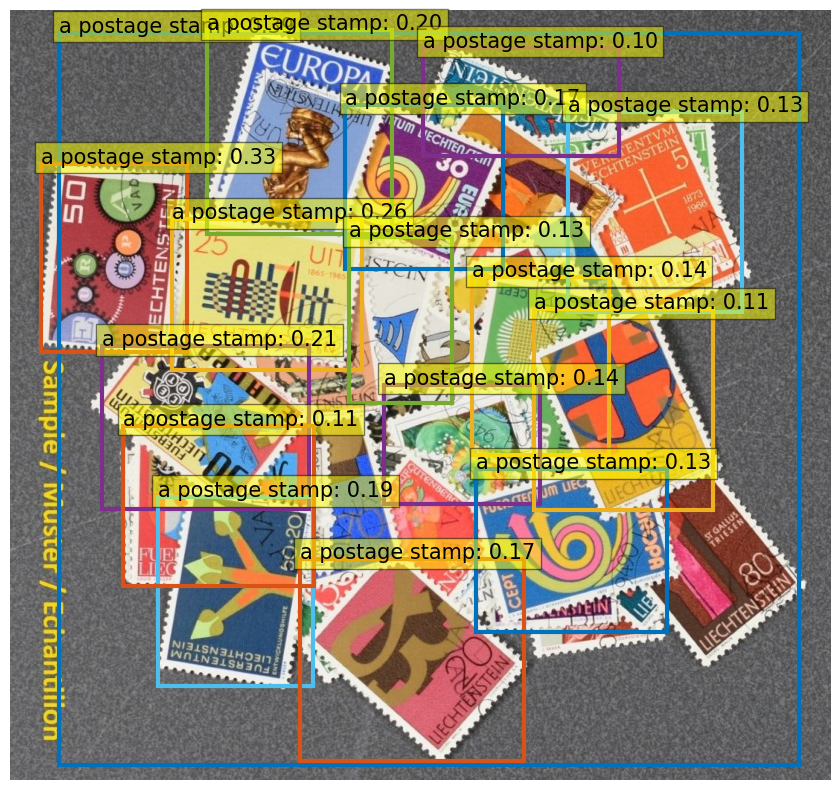

In [18]:
predictions = detector(album, candidate_labels=[preprocess_caption(text)])
print(predictions)

scores, labels, boxes = [], [], []
for prediction in predictions:
    scores.append(prediction["score"])
    labels.append(prediction["label"])
    boxes.append(tuple(prediction["box"].values()))

plot_results(album, scores, labels, boxes, text)


### Testing grounded-sam

In [19]:
import random
from dataclasses import dataclass
from typing import Any, List, Dict, Optional, Union, Tuple

import cv2
import torch
import requests
import numpy as np
from PIL import Image
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from transformers import AutoModelForMaskGeneration, AutoProcessor, pipeline


In [20]:
@dataclass
class BoundingBox:
    xmin: int
    ymin: int
    xmax: int
    ymax: int

    @property
    def xyxy(self) -> List[float]:
        return [self.xmin, self.ymin, self.xmax, self.ymax]

@dataclass
class DetectionResult:
    score: float
    label: str
    box: BoundingBox
    mask: Optional[np.array] = None

    @classmethod
    def from_dict(cls, detection_dict: Dict) -> 'DetectionResult':
        return cls(score=detection_dict['score'],
                   label=detection_dict['label'],
                   box=BoundingBox(xmin=detection_dict['box']['xmin'],
                                   ymin=detection_dict['box']['ymin'],
                                   xmax=detection_dict['box']['xmax'],
                                   ymax=detection_dict['box']['ymax']))

In [21]:
def annotate(image: Union[Image.Image, np.ndarray], detection_results: List[DetectionResult]) -> np.ndarray:
    # Convert PIL Image to OpenCV format
    image_cv2 = np.array(image) if isinstance(image, Image.Image) else image
    image_cv2 = cv2.cvtColor(image_cv2, cv2.COLOR_RGB2BGR)

    # Iterate over detections and add bounding boxes and masks
    for detection in detection_results:
        label = detection.label
        score = detection.score
        box = detection.box
        mask = detection.mask

        # Sample a random color for each detection
        color = np.random.randint(0, 256, size=3)

        # Draw bounding box
        cv2.rectangle(image_cv2, (box.xmin, box.ymin), (box.xmax, box.ymax), color.tolist(), 2)
        cv2.putText(image_cv2, f'{label}: {score:.2f}', (box.xmin, box.ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color.tolist(), 2)

        # If mask is available, apply it
        if mask is not None:
            # Convert mask to uint8
            mask_uint8 = (mask * 255).astype(np.uint8)
            contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            cv2.drawContours(image_cv2, contours, -1, color.tolist(), 2)

    return cv2.cvtColor(image_cv2, cv2.COLOR_BGR2RGB)

def plot_detections(
    image: Union[Image.Image, np.ndarray],
    detections: List[DetectionResult],
    save_name: Optional[str] = None
) -> None:
    annotated_image = annotate(image, detections)
    plt.imshow(annotated_image)
    plt.axis('off')
    if save_name:
        plt.savefig(save_name, bbox_inches='tight')
    plt.show()


In [22]:
def random_named_css_colors(num_colors: int) -> List[str]:
    """
    Returns a list of randomly selected named CSS colors.

    Args:
    - num_colors (int): Number of random colors to generate.

    Returns:
    - list: List of randomly selected named CSS colors.
    """
    # List of named CSS colors
    named_css_colors = [
        'aliceblue', 'antiquewhite', 'aqua', 'aquamarine', 'azure', 'beige', 'bisque', 'black', 'blanchedalmond',
        'blue', 'blueviolet', 'brown', 'burlywood', 'cadetblue', 'chartreuse', 'chocolate', 'coral', 'cornflowerblue',
        'cornsilk', 'crimson', 'cyan', 'darkblue', 'darkcyan', 'darkgoldenrod', 'darkgray', 'darkgreen', 'darkgrey',
        'darkkhaki', 'darkmagenta', 'darkolivegreen', 'darkorange', 'darkorchid', 'darkred', 'darksalmon', 'darkseagreen',
        'darkslateblue', 'darkslategray', 'darkslategrey', 'darkturquoise', 'darkviolet', 'deeppink', 'deepskyblue',
        'dimgray', 'dimgrey', 'dodgerblue', 'firebrick', 'floralwhite', 'forestgreen', 'fuchsia', 'gainsboro', 'ghostwhite',
        'gold', 'goldenrod', 'gray', 'green', 'greenyellow', 'grey', 'honeydew', 'hotpink', 'indianred', 'indigo', 'ivory',
        'khaki', 'lavender', 'lavenderblush', 'lawngreen', 'lemonchiffon', 'lightblue', 'lightcoral', 'lightcyan', 'lightgoldenrodyellow',
        'lightgray', 'lightgreen', 'lightgrey', 'lightpink', 'lightsalmon', 'lightseagreen', 'lightskyblue', 'lightslategray',
        'lightslategrey', 'lightsteelblue', 'lightyellow', 'lime', 'limegreen', 'linen', 'magenta', 'maroon', 'mediumaquamarine',
        'mediumblue', 'mediumorchid', 'mediumpurple', 'mediumseagreen', 'mediumslateblue', 'mediumspringgreen', 'mediumturquoise',
        'mediumvioletred', 'midnightblue', 'mintcream', 'mistyrose', 'moccasin', 'navajowhite', 'navy', 'oldlace', 'olive',
        'olivedrab', 'orange', 'orangered', 'orchid', 'palegoldenrod', 'palegreen', 'paleturquoise', 'palevioletred', 'papayawhip',
        'peachpuff', 'peru', 'pink', 'plum', 'powderblue', 'purple', 'rebeccapurple', 'red', 'rosybrown', 'royalblue', 'saddlebrown',
        'salmon', 'sandybrown', 'seagreen', 'seashell', 'sienna', 'silver', 'skyblue', 'slateblue', 'slategray', 'slategrey',
        'snow', 'springgreen', 'steelblue', 'tan', 'teal', 'thistle', 'tomato', 'turquoise', 'violet', 'wheat', 'white',
        'whitesmoke', 'yellow', 'yellowgreen'
    ]

    # Sample random named CSS colors
    return random.sample(named_css_colors, min(num_colors, len(named_css_colors)))

def plot_detections_plotly(
    image: np.ndarray,
    detections: List[DetectionResult],
    class_colors: Optional[Dict[str, str]] = None
) -> None:
    # If class_colors is not provided, generate random colors for each class
    if class_colors is None:
        num_detections = len(detections)
        colors = random_named_css_colors(num_detections)
        class_colors = {}
        for i in range(num_detections):
            class_colors[i] = colors[i]


    fig = px.imshow(image)

    # Add bounding boxes
    shapes = []
    annotations = []
    for idx, detection in enumerate(detections):
        label = detection.label
        box = detection.box
        score = detection.score
        mask = detection.mask

        polygon = mask_to_polygon(mask)

        fig.add_trace(go.Scatter(
            x=[point[0] for point in polygon] + [polygon[0][0]],
            y=[point[1] for point in polygon] + [polygon[0][1]],
            mode='lines',
            line=dict(color=class_colors[idx], width=2),
            fill='toself',
            name=f"{label}: {score:.2f}"
        ))

        xmin, ymin, xmax, ymax = box.xyxy
        shape = [
            dict(
                type="rect",
                xref="x", yref="y",
                x0=xmin, y0=ymin,
                x1=xmax, y1=ymax,
                line=dict(color=class_colors[idx])
            )
        ]
        annotation = [
            dict(
                x=(xmin+xmax) // 2, y=(ymin+ymax) // 2,
                xref="x", yref="y",
                text=f"{label}: {score:.2f}",
            )
        ]

        shapes.append(shape)
        annotations.append(annotation)

    # Update layout
    button_shapes = [dict(label="None",method="relayout",args=["shapes", []])]
    button_shapes = button_shapes + [
        dict(label=f"Detection {idx+1}",method="relayout",args=["shapes", shape]) for idx, shape in enumerate(shapes)
    ]
    button_shapes = button_shapes + [dict(label="All", method="relayout", args=["shapes", sum(shapes, [])])]

    fig.update_layout(
        xaxis=dict(visible=False),
        yaxis=dict(visible=False),
        # margin=dict(l=0, r=0, t=0, b=0),
        showlegend=True,
        updatemenus=[
            dict(
                type="buttons",
                direction="up",
                buttons=button_shapes
            )
        ],
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        )
    )

    # Show plot
    fig.show()


In [23]:
def mask_to_polygon(mask: np.ndarray) -> List[List[int]]:
    # Find contours in the binary mask
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the contour with the largest area
    largest_contour = max(contours, key=cv2.contourArea)

    # Extract the vertices of the contour
    polygon = largest_contour.reshape(-1, 2).tolist()

    return polygon

def polygon_to_mask(polygon: List[Tuple[int, int]], image_shape: Tuple[int, int]) -> np.ndarray:
    """
    Convert a polygon to a segmentation mask.

    Args:
    - polygon (list): List of (x, y) coordinates representing the vertices of the polygon.
    - image_shape (tuple): Shape of the image (height, width) for the mask.

    Returns:
    - np.ndarray: Segmentation mask with the polygon filled.
    """
    # Create an empty mask
    mask = np.zeros(image_shape, dtype=np.uint8)

    # Convert polygon to an array of points
    pts = np.array(polygon, dtype=np.int32)

    # Fill the polygon with white color (255)
    cv2.fillPoly(mask, [pts], color=(255,))

    return mask

def load_image(image_str: str) -> Image.Image:
    if image_str.startswith("http"):
        image = Image.open(requests.get(image_str, stream=True).raw).convert("RGB")
    else:
        image = Image.open(image_str).convert("RGB")

    return image

def get_boxes(results: DetectionResult) -> List[List[List[float]]]:
    boxes = []
    for result in results:
        xyxy = result.box.xyxy
        boxes.append(xyxy)

    return [boxes]

def refine_masks(masks: torch.BoolTensor, polygon_refinement: bool = False) -> List[np.ndarray]:
    masks = masks.cpu().float()
    masks = masks.permute(0, 2, 3, 1)
    masks = masks.mean(axis=-1)
    masks = (masks > 0).int()
    masks = masks.numpy().astype(np.uint8)
    masks = list(masks)

    if polygon_refinement:
        for idx, mask in enumerate(masks):
            shape = mask.shape
            polygon = mask_to_polygon(mask)
            mask = polygon_to_mask(polygon, shape)
            masks[idx] = mask

    return masks

In [33]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def detect(
    image: Image.Image,
    labels: List[str],
    threshold: float = 0.3,
    detector_id: Optional[str] = "IDEA-Research/grounding-dino-tiny"
) -> List[Dict[str, Any]]:
    """
    Use Grounding DINO to detect a set of labels in an image in a zero-shot fashion.
    """
    object_detector = pipeline(model=detector_id, task="zero-shot-object-detection", device=device)

    labels = [label if label.endswith(".") else label+"." for label in labels]

    results = object_detector(image,  candidate_labels=labels, threshold=threshold)
    print("results", results)
    results = [DetectionResult.from_dict(result) for result in results]

    return results

def segment(
    image: Image.Image,
    detection_results: List[Dict[str, Any]],
    polygon_refinement: bool = False,
    segmenter_id: Optional[str] = "facebook/sam-vit-base"
) -> List[DetectionResult]:
    """
    Use Segment Anything (SAM) to generate masks given an image + a set of bounding boxes.
    """
    segmentator = AutoModelForMaskGeneration.from_pretrained(segmenter_id).to(device)
    processor = AutoProcessor.from_pretrained(segmenter_id)

    boxes = get_boxes(detection_results)
    print(boxes, detection_results)
    inputs = processor(images=image, input_boxes=boxes, return_tensors="pt").to(device)

    outputs = segmentator(**inputs)
    masks = processor.post_process_masks(
        masks=outputs.pred_masks,
        original_sizes=inputs.original_sizes,
        reshaped_input_sizes=inputs.reshaped_input_sizes
    )[0]

    masks = refine_masks(masks, polygon_refinement)

    for detection_result, mask in zip(detection_results, masks):
        detection_result.mask = mask

    return detection_results

def grounded_segmentation(
    image: Union[Image.Image, str],
    labels: List[str],
    threshold: float = 0.3,
    polygon_refinement: bool = False,
    detector_id: Optional[str] = None,
    segmenter_id: Optional[str] = None
) -> Tuple[np.ndarray, List[DetectionResult]]:
    if isinstance(image, str):
        image = load_image(image)

    detections = detect(image, labels, threshold, detector_id)
    print("detections",detections)
    detections = segment(image, detections, polygon_refinement, segmenter_id)

    return np.array(image), detections


In [34]:
# image_url = "http://images.cocodataset.org/val2017/000000039769.jpg"
# labels = ["a cat.", "a remote control."]
# threshold = 0.3

detector_id = "google/owlvit-large-patch14"
segmenter_id = "facebook/sam-vit-huge"
# detector_id = "IDEA-Research/grounding-dino-tiny"
# segmenter_id = "facebook/sam-vit-base"

image_array, detections = grounded_segmentation(
    image=album,
    labels=labels,
    threshold=0.1,
    polygon_refinement=True,
    detector_id=detector_id,
    segmenter_id=segmenter_id
)


/Users/relaxxpls/Library/Caches/pypoetry/virtualenvs/stamps-search-7mpGafWP-py3.12/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


results [{'score': 0.16158662736415863, 'label': 'a postage stamp.', 'box': {'xmin': 55, 'ymin': 33, 'xmax': 1044, 'ymax': 1000}}, {'score': 0.16158662736415863, 'label': 'a postage stamp.', 'box': {'xmin': 55, 'ymin': 33, 'xmax': 1044, 'ymax': 1000}}, {'score': 0.16158662736415863, 'label': 'a postage stamp.', 'box': {'xmin': 55, 'ymin': 33, 'xmax': 1044, 'ymax': 1000}}, {'score': 0.16158662736415863, 'label': 'a postage stamp.', 'box': {'xmin': 55, 'ymin': 33, 'xmax': 1044, 'ymax': 1000}}, {'score': 0.16158662736415863, 'label': 'a postage stamp.', 'box': {'xmin': 55, 'ymin': 33, 'xmax': 1044, 'ymax': 1000}}, {'score': 0.16158662736415863, 'label': 'a postage stamp.', 'box': {'xmin': 55, 'ymin': 33, 'xmax': 1044, 'ymax': 1000}}, {'score': 0.16158662736415863, 'label': 'a postage stamp.', 'box': {'xmin': 55, 'ymin': 33, 'xmax': 1044, 'ymax': 1000}}, {'score': 0.16158662736415863, 'label': 'a postage stamp.', 'box': {'xmin': 55, 'ymin': 33, 'xmax': 1044, 'ymax': 1000}}, {'score': 0.161

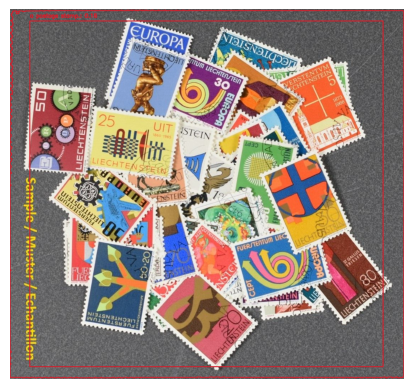

['a postage stamp.', 'a postage stamp.', 'a postage stamp.', 'a postage stamp.', 'a postage stamp.', 'a postage stamp.', 'a postage stamp.', 'a postage stamp.', 'a postage stamp.', 'a postage stamp.', 'a postage stamp.', 'a postage stamp.', 'a postage stamp.', 'a postage stamp.', 'a postage stamp.', 'a postage stamp.']


In [39]:
# plot_detections(image_array, detections)
plot_detections(image_array, detections)
# len(detections)
# plot_detections_plotly(image_array, detections)
print(labels)